In [50]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x2102cd4ebe0>)

In [36]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [37]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [38]:
print(train_data.info())
print('-'*50)
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB
None


In [39]:
train_data.drop_duplicates(subset=['document'], inplace=True) 

print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


In [40]:
train_data['label'].value_counts()

0    73342
1    72841
Name: label, dtype: int64

In [45]:
def delete_re_dm(dataframe,column):
    dataframe1 = dataframe.drop_duplicates(subset=[column], inplace=False)
    dataframe1[column] = dataframe1[column].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', "")
    dataframe1[column].replace('', np.nan, inplace=True)
    dataframe2 = dataframe1.dropna(how='any')
    dataframe2.reset_index(inplace=True)
    dataframe2.drop(columns = 'index', inplace=True)
    return dataframe2

def text_preprocessing(textlist):
    X_train = []
    i=0
    for sentence in tqdm(textlist):
        try:
            temp_X = []
            new_sentence = spacing(sentence)
            new_sentence = spell_checker.check(new_sentence).checked
            new_sentence = emoticon_normalize(new_sentence, num_repeats=2)
            temp_X = okt.morphs(new_sentence, norm=True, stem=True)
            temp_X = [w for w in temp_X if not w in stopwords]
            temp_X = [w for w in temp_X if len(w)>=2]
            X_train.append(temp_X)
        except Exception as e:
            temp_X = ['에러']
            X_train.append(temp_X)
            print(i,'번째에서 error 발생', e)
        i+=1
    return X_train

In [56]:
train_data = delete_re_dm(train_data,'document')

In [57]:
test_data = delete_re_dm(test_data,'document')

In [58]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [59]:
okt = Okt()

In [60]:
X_train = []
for sentence in tqdm(train_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

100%|█████████████████████████████████████████████████████████████████████████| 145791/145791 [15:22<00:00, 158.06it/s]


In [62]:
X_test = []
for sentence in tqdm(test_data['document']):
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

100%|███████████████████████████████████████████████████████████████████████████| 48417/48417 [06:01<00:00, 133.75it/s]


In [63]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [69]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


In [70]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [71]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [72]:
print(X_train[:3])

[[51, 455, 17, 261, 660], [934, 458, 42, 603, 2, 215, 1450, 25, 962, 676, 20], [387, 2445, 1, 2316, 5672, 3, 223, 10]]


In [73]:
len(X_train)

145791

In [81]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [82]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

145380
145380


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.002187371027652


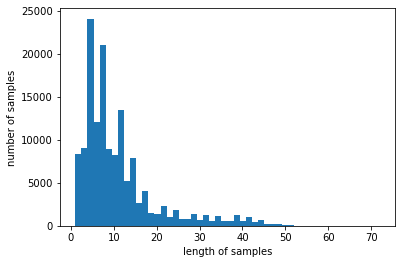

In [84]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [86]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [87]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.0830925849498


In [88]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [89]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [90]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [92]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1939/1939 [==============================] - 69s 35ms/step - loss: 0.4361 - acc: 0.7914 - val_loss: 0.3544 - val_acc: 0.8440

Epoch 00001: val_acc improved from -inf to 0.84400, saving model to best_model.h5
Epoch 2/15
1939/1939 [==============================] - 66s 34ms/step - loss: 0.3246 - acc: 0.8589 - val_loss: 0.3351 - val_acc: 0.8553

Epoch 00002: val_acc improved from 0.84400 to 0.85534, saving model to best_model.h5
Epoch 3/15
1939/1939 [==============================] - 67s 34ms/step - loss: 0.2971 - acc: 0.8738 - val_loss: 0.3298 - val_acc: 0.8571

Epoch 00003: val_acc improved from 0.85534 to 0.85706, saving model to best_model.h5
Epoch 4/15
1939/1939 [==============================] - 65s 33ms/step - loss: 0.2796 - acc: 0.8822 - val_loss: 0.3276 - val_acc: 0.8607

Epoch 00004: val_acc improved from 0.85706 to 0.86074, saving model to best_model.h5
Epoch 5/15
1939/1939 [==============================] - 66s 34ms/step - loss: 0.2625 - acc: 0.8935 - val_loss: 0.32

In [93]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 10s 6ms/step - loss: 0.3363 - acc: 0.8557

 테스트 정확도: 0.8557


In [94]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [101]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

94.84% 확률로 긍정 리뷰입니다.



In [102]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

98.58% 확률로 부정 리뷰입니다.



In [103]:
sentiment_predict('킬링타임용')

89.06% 확률로 부정 리뷰입니다.



In [104]:
sentiment_predict('이게 재밌냐')

86.38% 확률로 긍정 리뷰입니다.



In [105]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')


82.04% 확률로 긍정 리뷰입니다.

